# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import os
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# A. Load Data (a sample)

## 1. Train 

In [2]:
path ='../Kaggle_DSB_data/train.csv'
train = pd.read_csv(path, nrows=1000000, parse_dates=['timestamp'])

In [3]:
train['installation_id'] = train['installation_id'].apply(lambda x: int(x,16))

In [4]:
train = train.set_index(['installation_id','game_session'])

In [5]:
train.head()

event_id               timestamp                                         event_data  event_count  event_code  game_time                          title      type      world
installation_id game_session                                                                                                                                                                                 
125199          45bb1e1b6b50c07b  27253bdc 2019-09-06 17:53:46.937             {"event_code": 2000, "event_count": 1}            1        2000          0        Welcome to Lost Lagoon!      Clip       NONE
                17eeb7f223665f53  27253bdc 2019-09-06 17:54:17.519             {"event_code": 2000, "event_count": 1}            1        2000          0           Magma Peak - Level 1      Clip  MAGMAPEAK
                0848ef14a8dc6892  77261ab5 2019-09-06 17:54:56.302  {"version":"1.0","event_count":1,"game_time":0...            1        2000          0  Sandcastle Builder (Activity)  Activity  MAGMAPEAK
                0848ef14a8dc6892  b2dba42b 2019-09-06 17:54:56.387  {"description":"Let's build a sandcastle! Firs...            2        3010         53  Sandcastle Builder (Activity)  Activity  MAGMAPEAK
                0848ef14a8dc6892  1bb5fbdb 2019-09-06 17:55:03.253  {"description":"Let's build a sandcastle! Firs...            3        3110       6972  Sandcastle Builder (Activity)  Activity  MAGMAPEAK

### Remove Noisy Data

Noise: game_time =0  and incorrect 

## 2. Train Labels

In [6]:
path_labels ='../Kaggle_DSB_data/train_labels.csv'
train_labels = pd.read_csv(path_labels, nrows=1000000)

In [7]:
train_labels['installation_id'] = train_labels['installation_id'].apply(lambda x: int(x,16))

In [8]:
train_labels = train_labels.set_index(['installation_id','game_session'])

In [9]:
train_labels.head();

## 3. Merge all Assessment train data

In [10]:
assessments = pd.merge(train[train.type == 'Assessment'],
                     train_labels, left_index=True, right_index=True, how='inner')

# clean df
assessments = assessments.drop(['title_y','type'],axis=1)\
                         .rename({'title_x':'title'},axis=1)

In [11]:
assessments.head()

event_id               timestamp                                         event_data  event_count  event_code  game_time                         title        world  num_correct  num_incorrect  accuracy  accuracy_group
installation_id game_session                                                                                                                                                                                                                              
435871          6bdf9623adc94d89  3bfd1a65 2019-08-06 05:37:50.020  {"version":"1.0","event_count":1,"game_time":0...            1        2000          0  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  db02c830 2019-08-06 05:37:50.078  {"event_count":2,"game_time":77,"event_code":2...            2        2025         77  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  a1e4395d 2019-08-06 05:37:50.082  {"description":"Pull three mushrooms out of th...            3        3010         77  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  7da34a02 2019-08-06 05:37:52.799  {"coordinates":{"x":199,"y":484,"stage_width":...            4        4070       2784  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  28ed704e 2019-08-06 05:37:53.631  {"height":1,"coordinates":{"x":171,"y":519,"st...            5        4025       3625  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3

# B. Feature Engineering

Let's first try to construct "domain-like" features which might infleunce user performance. I'll divide these features into the following categories:

1. Level of game difficulty
2. User Expertise
3. User Focus 
4. Clarity of Game Instructions
5. Other



In [12]:
train.columns.tolist()

['event_id',
 'timestamp',
 'event_data',
 'event_count',
 'event_code',
 'game_time',
 'title',
 'type',
 'world']

## 1. Level of game difficulty

a) rate title based on user performance <br>
b) rate world based on user performance <br>



### a) Title

In [13]:
pct_corrects = lambda g: round(g.sum()/g.count(),3)
assess_title = assessments.groupby(['title'])[['num_correct']]\
                          .agg(['count','sum', pct_corrects])

In [14]:
# Clean df
assess_title.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_title['pct_incorrect'] =  1 - assess_title.pct_correct
assess_title.index = [title.split('(')[0].strip() for title in assess_title.index]

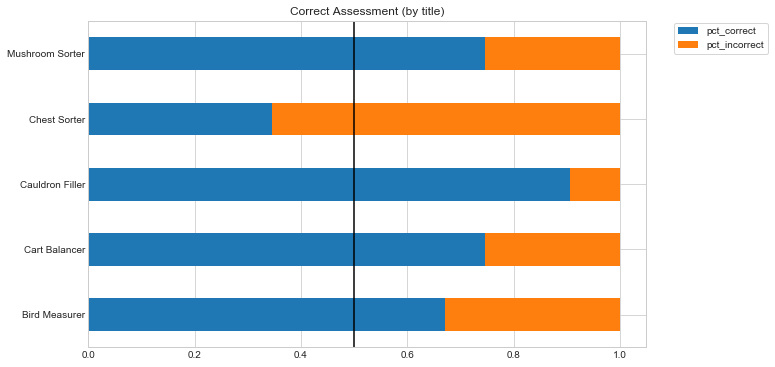

In [15]:
assess_title.loc[:,['pct_correct','pct_incorrect']]\
            .plot.barh(stacked=True,figsize=(10, 6), title='Correct Assessment (by title)')
plt.gca().legend(frameon=True,loc=(1.05,0.9))
plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')

### b) World

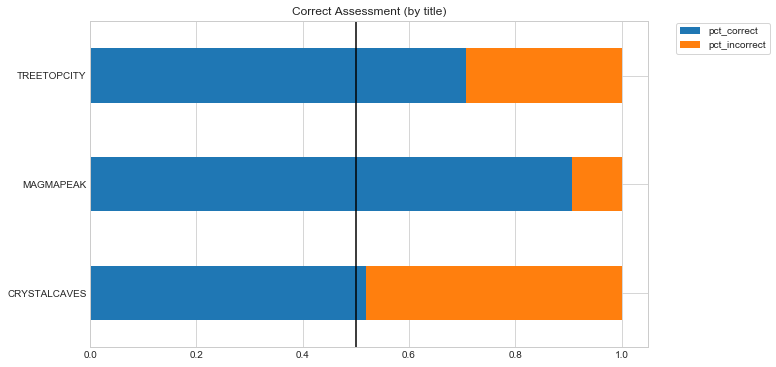

In [16]:
assess_world = assessments.groupby(['world'])[['num_correct']]\
                          .agg(['count','sum', pct_corrects])

# Clean df
assess_world.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_world['pct_incorrect'] =  1 - assess_world.pct_correct
assess_world.index = [title.split('(')[0].strip() for title in assess_world.index]

assess_world.loc[:,['pct_correct','pct_incorrect']]\
            .plot.barh(stacked=True,figsize=(10, 6), title='Correct Assessment (by title)')
plt.gca().legend(frameon=True,loc=(1.05,0.9))
plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')

## <font color='green'> Good Features: ```'world'``` and ```'title'``` </font> 

## 2. User Expertise

a) measure net game time <br>
b) measure net game time per title <br>
c) measure game time per world <br>
d) measure how the performance changes with time <br>
e) measure time of completion of each task <br>

### a) Net Game Time

In [17]:
def net_game_times(df):
    
    # drop game sessions with zero time
    df = df[df.game_time!=0]
    
    # compute total game time and number of sessions per id
    game_times = df.groupby('installation_id')['game_time']\
                   .agg(['sum','count'])\
                   .rename({'sum': 'net_time', 'count': 'num_sessions'}, axis=1)
    
    # convert milliseconds to mins
    game_times['net_time'] = game_times['net_time'].apply(lambda x: round(x/(1000*60),2))
    
    # compute avg game time per session
    game_times['avg_session_time'] = (game_times.net_time/game_times.num_sessions).apply(lambda x: round(x,2))
    
    return game_times
    

In [18]:
df_game_times = net_game_times(train)

In [19]:
df_game_times.head()

,net_time,num_sessions,avg_session_time
installation_id,,,
125199,4563.77,1347,3.39
280516,244.39,176,1.39
435871,5225.81,3711,1.41
442770,3350.77,2170,1.54
632233,2737.01,404,6.77


In [20]:
less_than = 1
print('Number of ids with net_time less than {0} min: {1}/{2}'
      .format(less_than, 
              np.sum(df_game_times['net_time']<less_than), 
              len(df_game_times))
     )

Number of ids with net_time less than 1 min: 22/1119


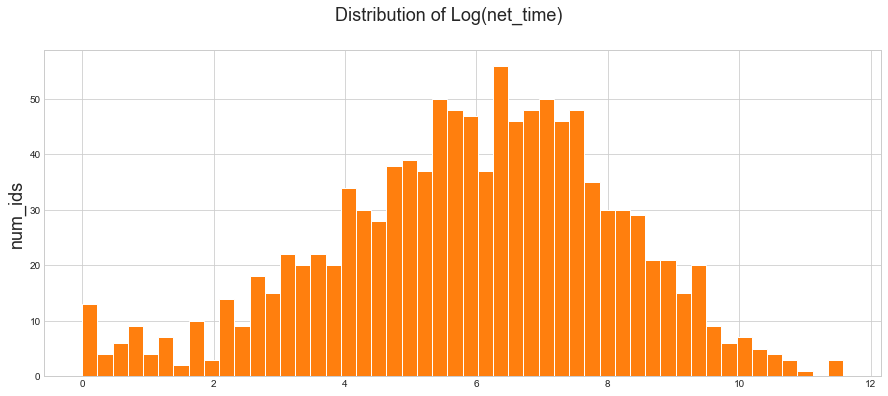

In [21]:
_ = df_game_times['net_time'].apply(np.log1p)\
                             .plot(kind='hist' ,bins=50,edgecolor='white',
                                   figsize=(15,6),color=my_pal[1])
                                   
_ = plt.gcf().suptitle("Distribution of Log(net_time)",fontsize = 18)
_ = plt.ylabel('num_ids', fontsize=18)



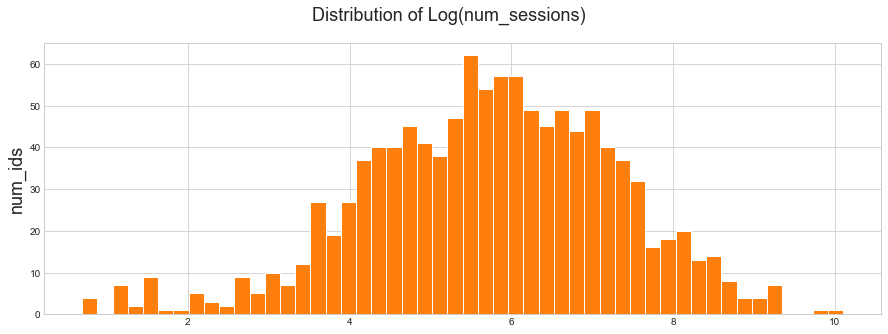

In [22]:
_ =df_game_times['num_sessions'].apply(np.log1p)\
                                .plot(kind='hist' ,bins=50,edgecolor='white',
                                   figsize=(15,5),color=my_pal[1])

_ = plt.gcf().suptitle("Distribution of Log(num_sessions)",fontsize = 18)
_ = plt.ylabel('num_ids', fontsize=18)
                                  

## <font color='green'> Good Features: game_time: ```['net_time','num_sessions', 'avg_session_time']``` </font> 

Comments: 
- perhaps use log of net_time and num_session
- treat differently ids with zero to less than a cut_off-value of game time


### b) Game Time per Title

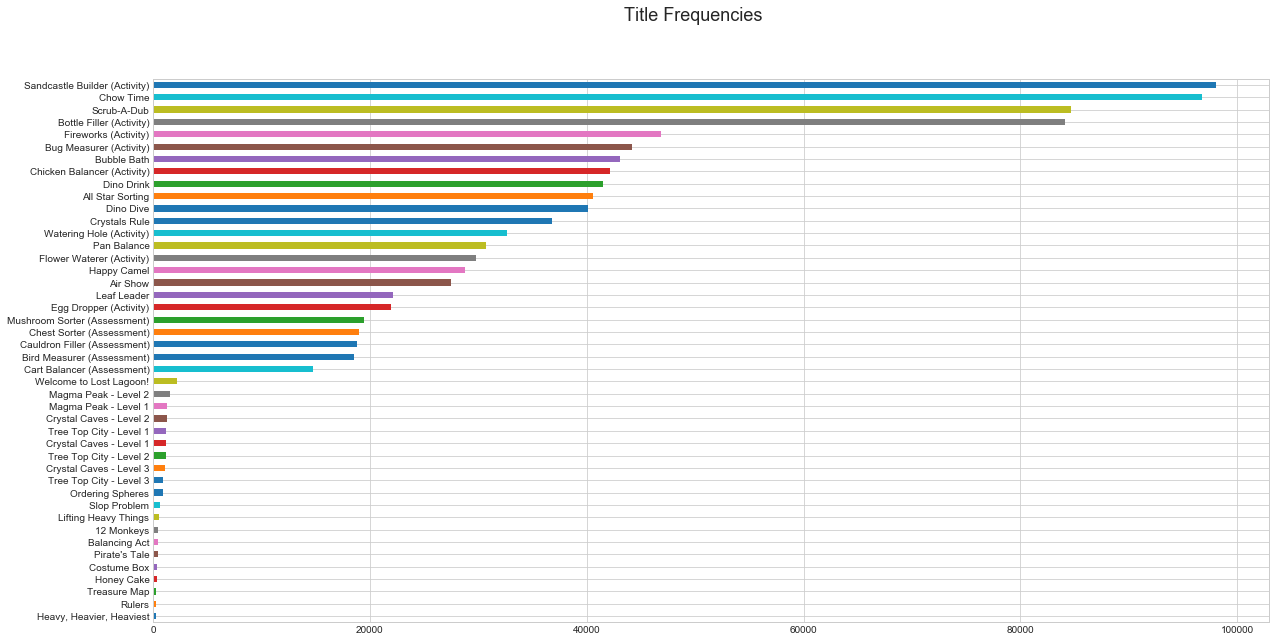

In [48]:
title_val_counts = train['title'].value_counts().sort_values()
_ = title_val_counts.plot(kind='barh',figsize=(20,10))
_ = plt.gcf().suptitle("Title Frequencies", size = 18)

In [23]:
def get_times_per_title(df):
    
    # drop game sessions with zero time
    df = df[df.game_time!=0]
    
    # compute total game time and number of sessions per id
    game_times = df.groupby(['installation_id','title'])['game_time']\
                   .agg(['sum','count'])\
                   .rename({'sum': 'net_time', 'count': 'num_sessions'}, axis=1)
    
    # convert milliseconds to mins
    game_times['net_time'] = game_times['net_time'].apply(lambda x: round(x/(1000*60),2))
    
    # compute avg game time per session
    game_times['avg_session_time'] = (game_times.net_time/game_times.num_sessions).apply(lambda x: round(x,2))
    
    return game_times
    

In [24]:
times_per_title = get_times_per_title(train)
times_per_title.head()

net_time  num_sessions  avg_session_time
installation_id title                                                                  
125199          Dino Drink                       304.08           141              2.16
                Sandcastle Builder (Activity)    495.32           466              1.06
                Scrub-A-Dub                     3764.37           740              5.09
280516          Dino Drink                       192.99           123              1.57
                Watering Hole (Activity)          51.40            53              0.97

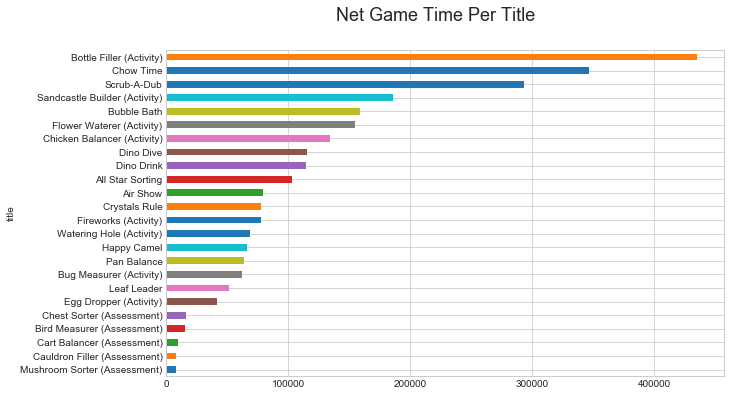

In [78]:
_ = times_per_title.groupby(level=1)['net_time']\
                   .sum()\
                   .sort_values()\
                   .plot(kind='barh',figsize=(10,6))

_ = plt.gcf().suptitle("Net Game Time Per Title", size = 18)

In [25]:
all_titles = list(set(times_per_title.index.get_level_values('title')))

In [26]:
times_per_title[times_per_title.index.get_level_values('title')==all_titles[0]]

,,net_time,num_sessions,avg_session_time
installation_id,title,,,
442770,Chicken Balancer (Activity),103.90,110,0.94
1218646,Chicken Balancer (Activity),496.37,199,2.49
1488844,Chicken Balancer (Activity),1049.56,501,2.09
2252647,Chicken Balancer (Activity),48.64,79,0.62
2595525,Chicken Balancer (Activity),237.01,119,1.99
2996195,Chicken Balancer (Activity),396.28,215,1.84
3371696,Chicken Balancer (Activity),67.71,79,0.86
5310031,Chicken Balancer (Activity),32.65,70,0.47
9966135,Chicken Balancer (Activity),0.18,2,0.09


## <font color='green'>  Good Features:  ```per title: net_time, num_sessions_, avg_session_time```<font>

### c) Game Time per World

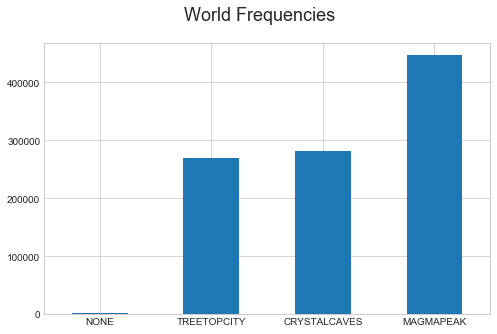

In [65]:
world_val_counts = train['world'].value_counts().sort_values()
_ = world_val_counts.plot(kind='bar',figsize=(8,5), color=my_pal[0])
_ = plt.gcf().suptitle("World Frequencies", size = 18)
ax = plt.gca()
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=0)

In [27]:
def get_times_per_world(df):
    
    # drop game sessions with zero time
    df = df[df.game_time!=0]
    
    # compute total game time and number of sessions per id
    game_times = df.groupby(['installation_id','world'])['game_time']\
                   .agg(['sum','count'])\
                   .rename({'sum': 'net_time', 'count': 'num_sessions'}, axis=1)
    
    # convert milliseconds to mins
    game_times['net_time'] = game_times['net_time'].apply(lambda x: round(x/(1000*60),2))
    
    # compute avg game time per session
    game_times['avg_session_time'] = (game_times.net_time/game_times.num_sessions).apply(lambda x: round(x,2))
    
    return game_times
    

In [28]:
times_per_world = get_times_per_world(train)
times_per_world.head()

net_time  num_sessions  avg_session_time
installation_id world                                                 
125199          MAGMAPEAK      4563.77          1347              3.39
280516          MAGMAPEAK       244.39           176              1.39
435871          MAGMAPEAK      2026.14          1872              1.08
                TREETOPCITY    3199.66          1839              1.74
442770          CRYSTALCAVES    156.40           194              0.81

In [29]:
all_worlds = list(set(times_per_world.index.get_level_values('world')))
all_worlds

['CRYSTALCAVES', 'MAGMAPEAK', 'TREETOPCITY']

In [30]:
times_per_world[times_per_world.index.get_level_values('world')==all_worlds[0]]

,,net_time,num_sessions,avg_session_time
installation_id,world,,,
442770,CRYSTALCAVES,156.40,194,0.81
1174984,CRYSTALCAVES,42.72,49,0.87
1218646,CRYSTALCAVES,496.37,199,2.49
1488844,CRYSTALCAVES,1388.79,788,1.76
1904336,CRYSTALCAVES,329.24,347,0.95
2167982,CRYSTALCAVES,0.69,4,0.17
2252647,CRYSTALCAVES,464.83,309,1.50
2595525,CRYSTALCAVES,5680.30,1478,3.84
2996195,CRYSTALCAVES,1209.62,791,1.53


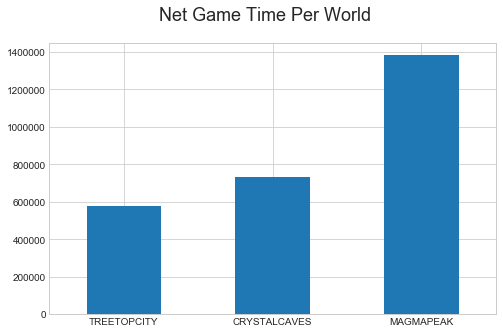

In [88]:
times_per_world.groupby(level=1)['net_time']\
               .sum()\
               .sort_values()\
               .plot(kind='bar',figsize=(8,5), color=my_pal[0])

_ = plt.gcf().suptitle("Net Game Time Per World", size = 18)
ax = plt.gca()
_ = ax.set_xlabel(ax.get_xlabel(),visible=False), ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


## <font color='green'>  Good Features:  ```per world: net_time, num_sessions_, avg_session_time```<font>

### e) Measure time of completion of each task (Activity)

## 3. User focus/activity

a) time of the day user signed in <br>
b) how much time spent per session <br>
c) boredom by playing too much?

### a) Hour of the day/ weekday signed in

In [138]:
def plot_assess_vs_timestamps(df, use_col='time'):
    df = df.groupby(use_col)[['num_correct']]\
           .agg(['count','sum', pct_corrects])

    # Clean df
    df.columns = ['num_assessments', 'num_correct', 'pct_correct']
    df['pct_incorrect'] =  1 - df.pct_correct
    
    # Plot accuracies
    df.loc[:,['pct_correct','pct_incorrect']]\
                .plot.barh(stacked=True,figsize=(10, 6), title=f'Correct Assessment (by {use_col})')
    plt.gca().legend(frameon=True,loc=(1.05,0.9))
    plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')
    
    
    return "STD of pct_correct for " + use_col + ": {:.2f}".format(df['pct_correct'].std())

In [142]:
assessments['hour'] = assessments['timestamp'].dt.hour
assessments['day'] = assessments['timestamp'].dt.day
assessments['weekday'] = assessments['timestamp'].dt.weekday
assessments['month'] = assessments['timestamp'].dt.month

'STD of pct_correct for day: 0.09'

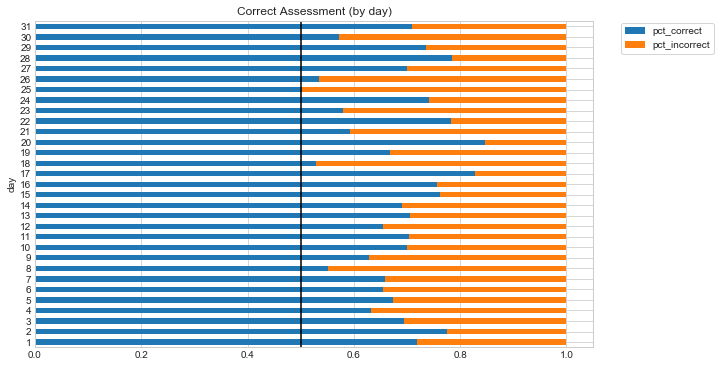

In [143]:
plot_assess_vs_timestamps(assessments, use_col='day')

The feature 'hour' has the highest STD (0.14) among: 'day' (0.09), 'weekday' (0.03), 'month' (0.03)

## <font color='green'>  Good Features:  ```timestamp: hour (perhaps day too)```<font>

### b) Time spent per session

In [146]:
time_per_sess = train.groupby(['installation_id','game_session']).agg({'event_count':'count','game_time':'sum'})

In [196]:
time_per_sess.head(10)

event_count  game_time
installation_id game_session                            
125199          04168b61c0650977            1          0
                07bacda7f9437b38          142   18244932
                0848ef14a8dc6892          267   21135461
                091587ed87b9637c            1          0
                17eeb7f223665f53            1          0
                3fce4f09769ff0b7            1          0
                45bb1e1b6b50c07b            1          0
                a1ec58f109218255           93    3349578
                ca8b415f34d12873          109    5234119
                f11eb823348bfa23          741  225861954

## <font color='green'>  Good Features:  ```time_per_sess, events_per_sess```<font>

### c) How often do they sign in AND play? And Why?

In [258]:
# collect "long" game sessions, i.e. sessions with more than one event
long_game_sess = time_per_sess[time_per_sess.event_count > 1].index

# select the beginning of all game sessions, i.e. the sign-in date
# and then filter out "short" sessions 
time_diff = train[train.event_count == 1].loc[long_game_sess, ['timestamp']]
time_diff['date'] = time_diff['timestamp'].dt.date

# count the number of days that a user has signed in (good sing-in's since long sessions)
time_diff = time_diff.groupby(['installation_id'])[['date']].nunique()

In [269]:
all_accuracies = assessments[assessments.game_time>0][['num_correct']].groupby('installation_id')[['num_correct']]\
                            .agg(['count','sum', pct_corrects])

# Clean df
all_accuracies.columns = ['num_assessments', 'num_correct', 'pct_correct']
all_accuracies['pct_incorrect'] =  1 - all_accuracies.pct_correct

In [290]:
multiple_signins = all_accuracies.reindex(time_diff[time_diff.date>1].index).dropna()
single_signins = all_accuracies.reindex(time_diff[time_diff.date==1].index).dropna()

In [299]:
multiple_signins[multiple_signins.num_correct>0].describe().applymap(lambda x: round(x,2))

,num_assessments,num_correct,pct_correct,pct_incorrect
count,209.00,209.00,209.00,209.00
mean,329.74,226.52,0.76,0.24
std,602.55,364.16,0.26,0.26
min,12.00,12.00,0.06,0.00
25%,96.00,56.00,0.59,0.00
50%,198.00,138.00,0.81,0.19
75%,346.00,258.00,1.00,0.41
max,7175.00,3877.00,1.00,0.94


In [300]:
single_signins[single_signins.num_correct>0].describe().applymap(lambda x: round(x,2))

,num_assessments,num_correct,pct_correct,pct_incorrect
count,83.00,83.00,83.00,83.00
mean,117.61,105.43,0.92,0.08
std,89.07,85.80,0.18,0.18
min,12.00,12.00,0.29,0.00
25%,50.00,44.50,1.00,0.00
50%,91.00,80.00,1.00,0.00
75%,157.00,136.00,1.00,0.00
max,436.00,436.00,1.00,0.71


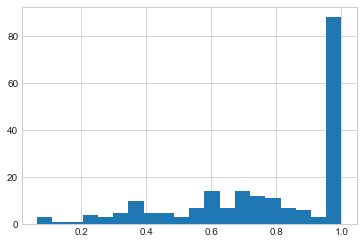

In [305]:
multiple_signins[multiple_signins.num_correct>0]['pct_correct'].hist(bins=20)

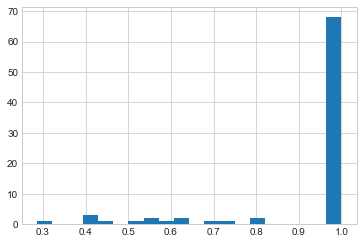

In [304]:
single_signins[single_signins.num_correct>0]['pct_correct'].hist(bins=20)

Comment: users with single sign-ins have quite higher accuracy than users with multiple sing-ins. Perhaps single-sing-ins users need less time to advance as players and pass the different tasks. Or perhaps they spent time doing only the easy tasks and then skipped the difficult tasks or gave up.

Note: some players might have signed in from different devices (i.e. with different ids)

## <font color='green'>  Good Features:  ```user sign-ins```<font>

## 4. Clarity of game instructions

Game Clarity:<br>
a) rate hints based on user performance <br>
b) check if the user was doing something weird: from coords (e.g. false negatives) <br>
c) check if the user was doing something weird to familiarize himself/herself with the game (e.g. at the beginnig might press randomly)